In [11]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/NLP-POS"
DATA_DIR = f"{BASE_DIR}/data/processed"
MODEL_DIR = f"{BASE_DIR}/models"

import os
os.makedirs(MODEL_DIR, exist_ok=True)

print("Directories ready.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directories ready.


In [8]:
!pip install scikit-learn tqdm

In [9]:
import numpy as np
import pickle
import json
import os
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

In [12]:
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
X_dev   = np.load(os.path.join(DATA_DIR, "X_dev.npy"))
X_test  = np.load(os.path.join(DATA_DIR, "X_test.npy"))

y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_dev   = np.load(os.path.join(DATA_DIR, "y_dev.npy"))
y_test  = np.load(os.path.join(DATA_DIR, "y_test.npy"))

# Dictionaries
with open(os.path.join(DATA_DIR, "word2id.pkl"), "rb") as f:
    word2id = pickle.load(f)
with open(os.path.join(DATA_DIR, "id2word.pkl"), "rb") as f:
    id2word = pickle.load(f)

with open(os.path.join(DATA_DIR, "tag2id.pkl"), "rb") as f:
    tag2id = pickle.load(f)
with open(os.path.join(DATA_DIR, "id2tag.pkl"), "rb") as f:
    id2tag = pickle.load(f)

with open(os.path.join(DATA_DIR, "max_len.json"), "r") as f:
    max_len = json.load(f)

print("Loaded all files successfully.")

Loaded all files successfully.


In [14]:
def idx_seq_to_words(seq):
    return [id2word[int(i)] for i in seq if int(i) > 0]

def idx_seq_to_tags(seq):
    return [id2tag[int(i)] for i in seq if int(i) > 0]

train_words = [idx_seq_to_words(x) for x in X_train]
train_tags  = [idx_seq_to_tags(y) for y in y_train]

dev_words = [idx_seq_to_words(x) for x in X_dev]
dev_tags  = [idx_seq_to_tags(y) for y in y_dev]

test_words = [idx_seq_to_words(x) for x in X_test]
test_tags  = [idx_seq_to_tags(y) for y in y_test]

print("Converted IDs → text.")

Converted IDs → text.


In [18]:
def clean_pairs(words_list, tags_list):
    clean = []
    for w, t in zip(words_list, tags_list):
        if len(w) == len(t) and len(w) > 0:
            clean.append((w, t))
    return clean

train_pairs = clean_pairs(train_words, train_tags)
dev_pairs   = clean_pairs(dev_words, dev_tags)
test_pairs  = clean_pairs(test_words, test_tags)

print("Train sentences:", len(train_pairs))
print("Dev sentences:", len(dev_pairs))
print("Test sentences:", len(test_pairs))

Train sentences: 3984
Dev sentences: 384
Test sentences: 124


In [19]:
def word2features(sent, i, prev_tag):
    word = sent[i].lower()

    features = {
        "bias": 1.0,
        "word.lower": word,
        "prev_tag": prev_tag,
    }

    if i > 0:
        features["prev_word"] = sent[i-1].lower()
    if i < len(sent)-1:
        features["next_word"] = sent[i+1].lower()

    return features

In [20]:
vectorizer = DictVectorizer(sparse=True)

X_feats = []
y_flat  = []

for sent_words, sent_tags in tqdm(train_pairs):
    prev_tag = "<START>"
    for i in range(len(sent_words)):
        feats = word2features(sent_words, i, prev_tag)
        X_feats.append(feats)
        y_flat.append(sent_tags[i])
        prev_tag = sent_tags[i]

X_train_vec = vectorizer.fit_transform(X_feats)
y_train_vec = np.array(y_flat)

print("Feature extraction complete.")
print("X shape:", X_train_vec.shape)
print("y shape:", y_train_vec.shape)

100%|██████████| 3984/3984 [00:00<00:00, 17468.25it/s]


Feature extraction complete.
X shape: (77124, 43955)
y shape: (77124,)


In [21]:
memm = LogisticRegression(
    max_iter=200,
    n_jobs=-1,
    solver="lbfgs",
    multi_class="multinomial"
)

memm.fit(X_train_vec, y_train_vec)
print("MEMM training complete.")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


MEMM training complete.


In [22]:
def memm_predict_sentence(words):
    prev_tag = "<START>"
    preds = []

    for i in range(len(words)):
        feats = word2features(words, i, prev_tag)
        vec = vectorizer.transform([feats])
        pred = memm.predict(vec)[0]
        preds.append(pred)
        prev_tag = pred

    return preds

y_true = []
y_pred = []

for words, tags in tqdm(test_pairs):
    pred = memm_predict_sentence(words)
    y_true.extend(tags)
    y_pred.extend(pred)

print(classification_report(y_true, y_pred))
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

100%|██████████| 124/124 [00:15<00:00,  8.26it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         ADP       0.99      1.00      0.99       367
         ADV       1.00      0.79      0.88        94
         AUX       0.89      0.75      0.81        72
       CCONJ       1.00      0.86      0.92        71
         DET       0.98      0.97      0.97       331
        INTJ       0.00      0.00      0.00         1
        NOUN       0.84      0.84      0.84       401
         NUM       1.00      0.66      0.80        74
        PRON       0.92      0.86      0.89        99
       PROPN       0.58      0.81      0.68       218
       PUNCT       1.00      0.99      1.00       302
       SCONJ       0.86      0.91      0.89        68
         SYM       0.86      0.55      0.67        11
        VERB       0.80      0.80      0.80       266
           X       0.00      0.00      0.00        10

    accuracy                           0.88      2385
   macro avg       0.78      0.72      0.74      2385
weighted avg       0.89   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


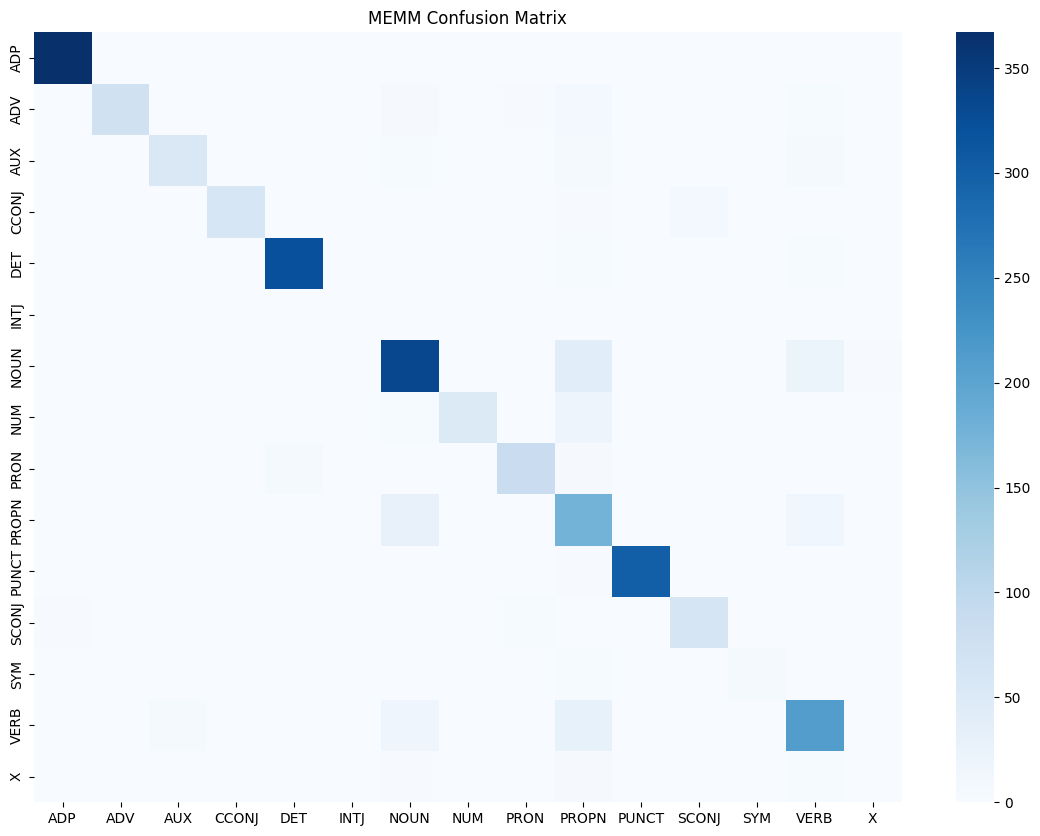

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(list(set(y_true)))

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("MEMM Confusion Matrix")
plt.show()

In [26]:
with open(os.path.join(MODEL_DIR, "memm_model.pkl"), "wb") as f:
    pickle.dump(memm, f)

with open(os.path.join(MODEL_DIR, "memm_vectorizer.pkl"), "wb") as f:
    pickle.dump(vectorizer, f)

print("Saved MEMM model + vectorizer.")

Saved MEMM model + vectorizer.
